# Electric Rotor Temperature Prediction

Programming Language: R 3.5.1 in Jupyter Notebook

R Libraries used:
- psych
- ggplot2
- gridExtra
- GGaly
- leaps
- glmnet

In [149]:
library(psych)
library(ggplot2)
library(gridExtra) 
library(GGally)
library(leaps)
library(glmnet)

## Table of Contents

1. [Introduction](#sec_1)    
1.1 [Data Description](#sec_1.1)
    
2. [Exploratory Data Analysis](#sec_2)                                                    
2.1 [Exploration](#sec_2.1)                          
2.2 [Correlation](#sec_2.2)
3. [Methodology](#sec_3)                            
4. [Model Development](#sec_4)                    
4.1 [Stepwise Selection of Predictors](#sec_4.1)                                  
4.2 [Model 1.1 - Linear Model](#sec_4.2)  
4.3 [Stepwise Selection of Interactions and Transformations](#sec_4.3)     
4.4 [Model 1.2 - Linear Model](#sec_4.4)                                    
4.5 [Comparison between Linear Models](#sec_4.5)                        
4.6 [Model 2 -  Regularization](#sec_4.6)
3. [Results and discussion](#sec_5)
3. [Conclusion](#sec_6)
3. [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>
The main purpose of the data set's recording is to be able to model the rotor temperatures of a permanent magnet synchronous motor (PMSM) in real-time. Due to the intricate structure of an electric traction drive, direct measurement with thermal sensors is not possible for rotor temperatures, and even in case of the stator temperatures, sensor outage or even just deterioration can’t be administered properly without redundant modeling. In addition, precise thermal modeling gets more and more important with the rising relevance of functional safety.

### 1.1 Data Description <a class="anchor" id="sec_1.1"></a>
The data set contains 15,147 instances, each of which have 13 columns

#### Attributes 
- **ambient:** *(Numeric)*
Ambient temperature as measured by a thermal sensor located closely to the stator.

- **coolant:** *(Numeric)*
Coolant temperature. The motor is water cooled. Measurement is taken at outflow.

- **u_d:** *(Numeric)*
Voltage d-component

- **u_q:** *(Numeric)*
Voltage q-component

- **motor_speed:** *(Numeric)*
Motor speed

- **torque:** *(Numeric)*
Torque induced by current.

- **i_d:** *(Numeric)*
Current d-component

- **i_q:** *(Numeric)*
Current q-component

#### Target
- **pm:** *(Numeric)*
Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.


## 2. Exploratory Data Analysis<a class="anchor" id="sec_2"></a>

#### Read Data

In [3]:
df <- read.csv('./pmsm_temperature_data_A1_2021.csv', header = TRUE)

#### Wrangling Data
Even though in the instructions is said that the dataset does not need wrangling, it also says that: "the three original target features `stator yoke`, `stator winding` and `stator tooth` should not be used". Besides, `profile_id` is not mentioned as an attribute. Therefore, we proceed to remove those columns of the dataframe

In [4]:
df <- subset(df, select=-c(stator_yoke, stator_tooth, stator_winding, profile_id))
head(df)

ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
0.1176819,-1.040829,-1.0267303,0.9250645,1.2124813,0.3586899,-0.8343090,0.3229330,-0.08831267
-0.5547717,-1.087189,-1.2258921,0.5125759,2.0241232,0.2841797,-1.3638294,0.2340145,0.71040170
-0.7722329,-1.063652,0.2988575,0.9562448,-0.1402458,-0.2591392,1.0291220,-0.2457111,-1.59260400
0.2199584,-1.083475,-1.0261079,0.9278145,1.2124836,0.3574240,-0.8381095,0.3228101,-0.14167030
0.4015749,-1.078981,0.3155328,-0.7094008,-0.9518901,-0.2562895,1.0291730,-0.2457109,-1.96488810
-0.7697667,-1.089577,0.2999456,0.9589649,-0.1402460,-0.2592790,1.0291333,-0.2457186,-1.77564350


In [5]:
cat("The dataset has", dim(df)[1], "rows and", dim(df)[2], "columns")

The dataset has 15147 rows and 9 columns

#### Exploration<a class="anchor" id="sec_2.1"></a>

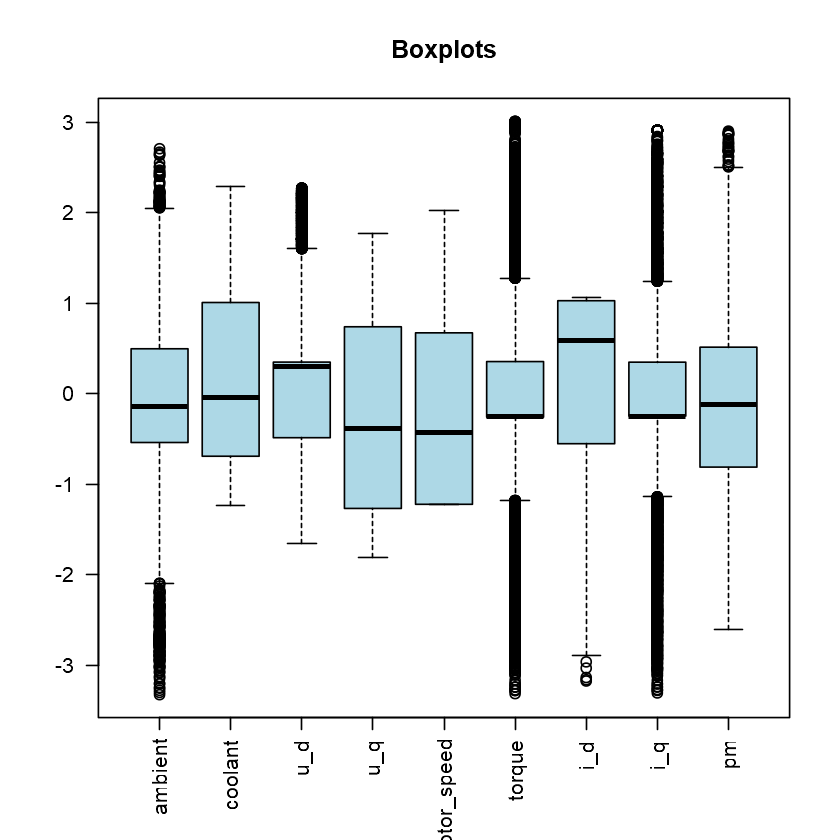

In [6]:
boxplot(df, main = "Boxplots", col = 'lightblue', las=2)

In [7]:
round(describe(df), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ambient,1,15147,-0.107,0.833,-0.140,-0.062,0.721,-3.328,2.711,6.038,-0.648,1.806,0.007
coolant,2,15147,0.181,1.032,-0.045,0.111,1.179,-1.237,2.295,3.532,0.462,-1.073,0.008
u_d,3,15147,0.110,0.922,0.300,0.095,0.581,-1.654,2.273,3.927,0.018,-0.178,0.007
u_q,4,15147,-0.191,1.050,-0.381,-0.277,1.351,-1.815,1.770,3.585,0.419,-1.266,0.009
motor_speed,5,15147,-0.191,1.027,-0.432,-0.294,1.172,-1.222,2.024,3.247,0.538,-1.106,0.008
torque,6,15147,-0.084,0.917,-0.256,-0.093,0.489,-3.316,3.014,6.330,0.162,1.439,0.007
i_d,7,15147,0.177,0.969,0.587,0.316,0.655,-3.176,1.060,4.237,-0.835,-0.471,0.008
i_q,8,15147,-0.081,0.917,-0.246,-0.089,0.537,-3.309,2.914,6.223,0.123,1.441,0.007
pm,9,15147,-0.127,0.920,-0.121,-0.121,0.982,-2.605,2.905,5.510,-0.014,-0.238,0.007


With the `boxplot` and the `summary` of each attribute of the dataframe we can identify many things in each attribute:

- There are 5 attributes out of 8 that has outliers in the data, we have to be careful with these variables, because these outliers can cause errors in the model. The attibutes with outliers are:
    - ambient
    - u_d
    - torque
    - i_d
    - 1_q
    
    
    
- There is only two attributes `ambient` and `i_d` that has <font color = "darkred">negative</font> skewness
- We do not have missing values as all attributes has the same number of rows (15.147)
- The attributes with the bigger range `ambient`, `torque` and `i_q` (range ~ 6) are the same with a high and <font color= "darkgreen"> positive</font> Kurtosis. While the attributes with the smaller range `coolant`, `u_d`, `u_q` and `motor_speed` (range ~ 3) are the same with the <font color = "darkred"> negative</font> Kurtosis.
- Surprinssingly the `Standard Error` of all of the attibutes are very similar, all of them between 0.007 and 0.009
- It seems that each records of each attribute is the standarised value with the mean $\mu$ and the standard deviation $\sigma$ with the following formula:

$$\text{std value} = \frac{value - \mu}{\sigma}$$
    
- Assuming that the last assumptions is true and that the attributes are normally distributed, having values bigger than 3 or smaller than -3 is very unlikely. Less than 0.27% 

In [8]:
sort(round(apply(df, 2, sd),3))

ambient      torque         i_q          pm         u_d         i_d 
      0.833       0.917       0.917       0.920       0.922       0.969 
motor_speed     coolant         u_q 
      1.027       1.032       1.050

The attribute with the highest standard deviation is `u_q`, and lowest standard deviation is `ambient` what lead us to think that the rotor is located in place where the tempature of the ambient could be regulated.

#### Correlation<a class="anchor" id="sec_2.2"></a>
After exploring the values of each attribute, we proceed to find the correlation between the attributes without the target value. As then we are going to find this with the model

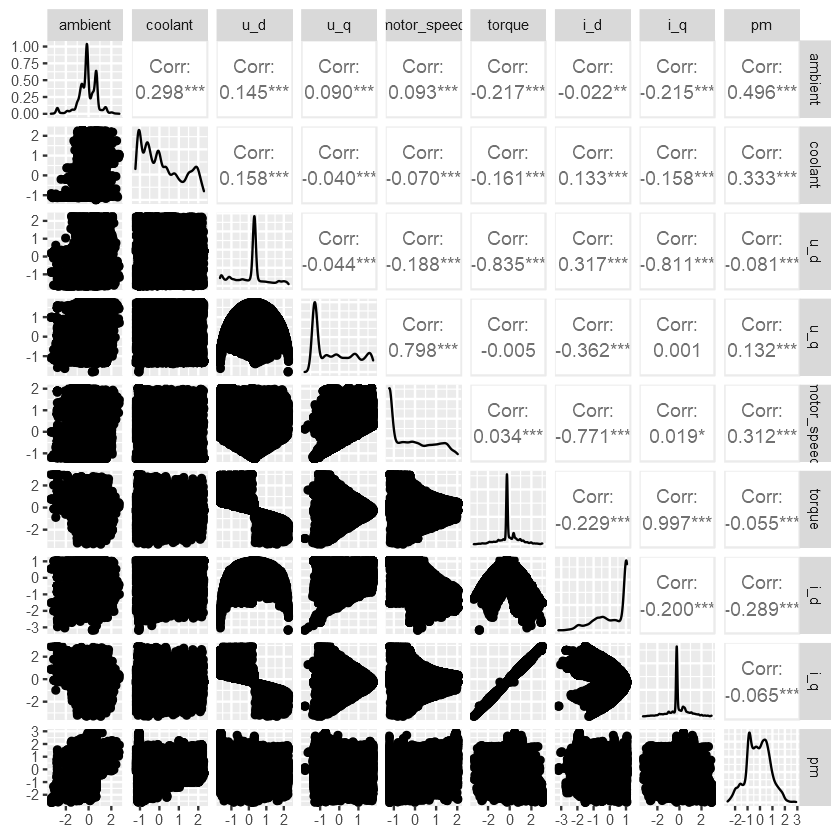

In [9]:
ggpairs(df)

* The attibutes `ambient` and `coolant` have weak correlations with all the other attibutes, even though they hava a moderate <font color = "darkgreen">positive</font> correlation with the target value `pm`. It makes too much sense as the configuration of the motor does not depend of the ambient and coolant temparature but on the needs of the plant. But if the ambient or the coolant are hot the rotor is more likely to be hot too. 

* `motor_speed` is strongly correlated to two different attributes: <font color= "darkred">negative</font> relationship with `i_d` and <font color= "darkgreen">positive </font> relationship with `u_q`. What can lead us to think that these two parameters are configurated by the operator of the rotor to change the `motor_speed`.

* `torque` is strongly correlated to two different attributes: <font color= "darkred">negative</font> relationship with `u_d` and <font color= "darkgreen">positive </font> relationship with `i_q`. What can lead us to think that these two parameters are configurated by the operator of the rotor to change the `torque`.

* We have to be careful with the relationship between `i_q` and `torque` because its correlation is almost 1 and we can have problem with colinearity, that is why it could be good to remove one attribute from the model 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


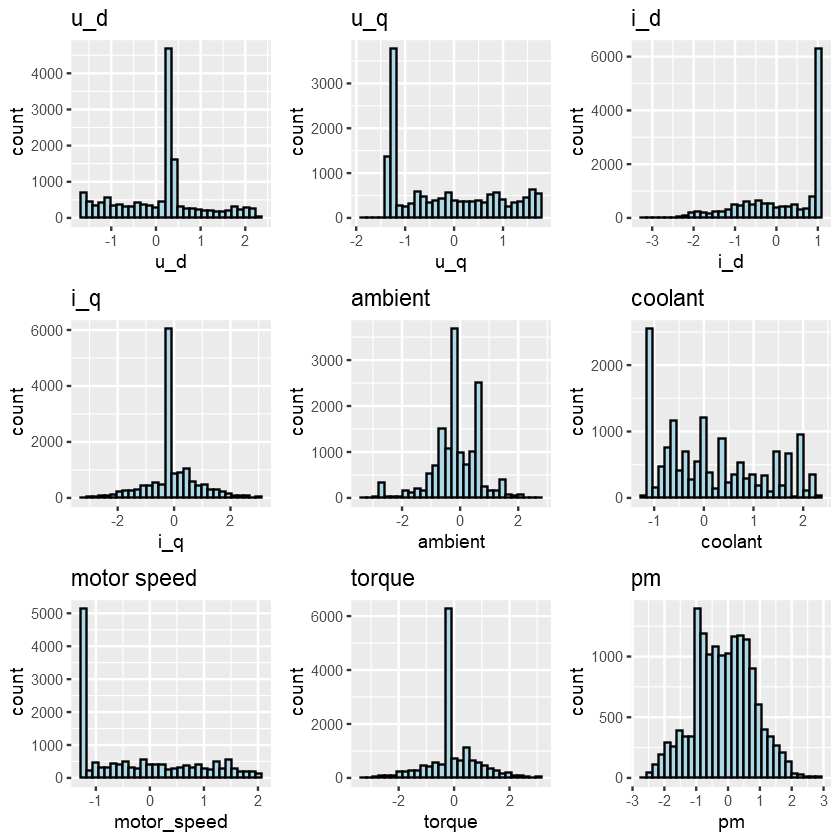

In [10]:
p1<-ggplot(aes(x=u_d), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('u_d')

p2<-ggplot(aes(x=u_q), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('u_q')

p3<-ggplot(aes(x=i_d), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('i_d')

p4<-ggplot(aes(x=i_q), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('i_q')

p5<-ggplot(aes(x=ambient), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('ambient')

p6<-ggplot(aes(x=coolant), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('coolant')

p7<-ggplot(aes(x=motor_speed), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('motor speed')

p8<-ggplot(aes(x=torque), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('torque')

p9<-ggplot(aes(x=pm), data = df) +
    geom_histogram(color = I('black'), fill = "lightblue") + 
    ggtitle('pm')

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, ncol = 3)

By looking at these histograms we can observe that there is no normal behavior in any attribute, each of them has a preferred configuration as it can be seen with the tallest bin (mode). Even though, the target value `pm` seems to have a normal distribution due to all configurations given, that is why we are going to proceed to build a model and try to predict the temperature of the rotor `pm` based on the other attributes


## 3. Methodology<a class="anchor" id="sec_3"></a>

#### 1. Perform Stepwise selection to get the best predictors
By using the `stepwise selection` in all the predictors of the model, we can find out which are the most relevant attributes of the model.

#### 2. Model the selected predictor with Linear Regression Model
After getting the most relevant predictors, we proceed to model `pm` with the attributes, then we are going to verify the three principles of a linear model that are:
   - **Linearity:** Check that the residuals follow a straight line around zero
   - **Normality:** Check that the residuals are linear in a QQ plot
   - **Constant Variance:** Check that the residuals follow a straight horizontal line around the constant varince

#### 3. Perform Stepwise selection to get the best interactions and transformations
By using again the `stepwise selection` in all the predictors, transformations and interactions of the model, we can find finally the most relevant attributes in order to predict the `pm` value.

#### 4. Check again Linearity, Normality and Constant Variance

#### 5. Comparison between models
After we have two different linear models: one with just predictors and other one with predictors and interations. We can check which model has a better performance, and finally with an ANOVA test we can identify if they are different from each other in order to understand if the interactions between predictor have a good or bad impact on the performance of model.

#### 6. Create Lasso Regularization Model
In this step we do not have to select the predictors of the model manually, as it does it itself. Therefore, we are going to input all the predictors and we let the algorithm prune them and fine with cross-validation method, the best predictors for `pm`

#### 7. Create Ridge Regularization Model
We will perform the same methodology applied with Lasso Regularization Model


#### 7. Comparison between Models
After having three different models, we proceed to compare the performance of each model by using different methods, the first one is compare them with Adjusted $R^2$, which one is higher and closer to 1. We have to be careful about this parameter because if it is too close to 1 it could be also a signal of overfitting. 
That is why we are also going to use MSE and see which model has lower Mean Squared Error. To do this, first we have to split the dataframe given in two different datasets: One for training and one for testing

In [11]:
set.seed(1234) # Set Seed so that same sample can be reproduced in future also
# Now Selecting 70% of data as sample from total 'n' rows of the data  
sample <- sample.int(n = nrow(df), size = floor(0.7*nrow(df)), replace = F)
train <- df[sample, ]

With `train` dataset we are going to create the models, compare them using statistics and plots in order to find the best model, judging by the performance.

After choosing the best model we are going to test each model using the `test` dataframe and then select them best model between `linear model`, `Lasso Regularization`, and `Ridge Regularization` using MSE and plot methods

In [12]:
test <- df[-sample, ]

## 4. Model Development <a class="anchor" id="sec_4"></a>

### 4.1 Stepwise Selection of Predictors <a class="anchor" id="sec_4.1"></a>
First we are going to use the all the predictors given in the dataset, without using `i_q` and `torque` to avoid colinearity problems as mentioned above, to find out which predictors have more influency `pm` value:

$$\hat{Y} = \beta_0 + \beta_1 \text{ambient} + \beta_2 \text{coolant} + \beta_3 \text{u_d} + \beta_4 \text{u_q} + \beta_5 \text{motor_speed} + \beta_6 \text{i_d} $$

With the stepwise selections we prune predictors, in order to get the best model, with the less predictors possible as follows.

In [13]:
model.1 <- regsubsets(pm ~ ., data = train, nvmax = 8) 
summary.model.1 <- summary(model.1)

After we model the formula we are going to review which are the most important predictor to `pm` with for different methods:
   - Mallows's Cp
   - BIC
   - Adjusted $R^2$
   - RSS

With these four methods we are trying to find the predictors that minimize the CP, BIC and RSS but at the same time maximize the Adjusted $R^2$. To do that we are going to use plots that show us each parameter for different subsets of predictors.

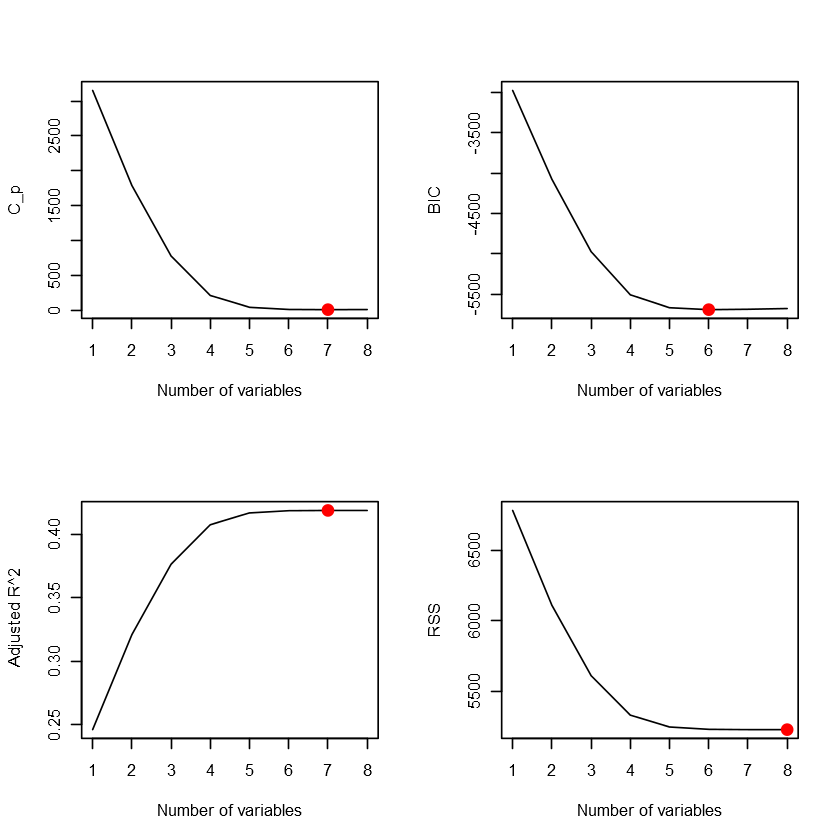

In [14]:
par(mfrow = c(2, 2))
plot(summary.model.1$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(summary.model.1$cp), summary.model.1$cp[which.min(summary.model.1$cp)], col = "red", cex = 2, pch = 20)
plot(summary.model.1$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(summary.model.1$bic), summary.model.1$bic[which.min(summary.model.1$bic)], col = "red", cex = 2, pch = 20)
plot(summary.model.1$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(summary.model.1$adjr2), summary.model.1$adjr2[which.max(summary.model.1$adjr2)], col = "red", cex = 2, pch = 20)
plot(summary.model.1$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
points(which.min(summary.model.1$rss), summary.model.1$rss[which.min(summary.model.1$rss)], col = "red", cex = 2, pch = 20)

By looking at these four plots we identify that the best subset is the one with 7 predictors, as this subset has the smallest `C_p` and `RSS`. Even though the model with 6 predictors is the one with the least `BIC`, and the model with 8 predictors is the one with **highest** $R^2$ Adjusted. 
After identifying this, we decided that the model with 7 predictors it the most optimum

At this moment we do not know which predictors are in these subsets. That is why we proceed to understand what subsets were selected by the model. 

In [15]:
summary.model.1

Subset selection object
Call: regsubsets.formula(pm ~ ., data = train, nvmax = 8)
8 Variables  (and intercept)
            Forced in Forced out
ambient         FALSE      FALSE
coolant         FALSE      FALSE
u_d             FALSE      FALSE
u_q             FALSE      FALSE
motor_speed     FALSE      FALSE
torque          FALSE      FALSE
i_d             FALSE      FALSE
i_q             FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: exhaustive
         ambient coolant u_d u_q motor_speed torque i_d i_q
1  ( 1 ) "*"     " "     " " " " " "         " "    " " " "
2  ( 1 ) "*"     " "     " " " " " "         " "    "*" " "
3  ( 1 ) "*"     "*"     " " " " " "         " "    "*" " "
4  ( 1 ) "*"     "*"     " " "*" "*"         " "    " " " "
5  ( 1 ) "*"     "*"     "*" "*" "*"         " "    " " " "
6  ( 1 ) "*"     "*"     "*" "*" "*"         "*"    " " " "
7  ( 1 ) "*"     "*"     "*" "*" "*"         "*"    " " "*"
8  ( 1 ) "*"     "*"     "*" "*" "*"         "*" 

The least important predictors for **pm** is `i_d` as it can be seen in the **Selection Algorithm**. By performing the subseting method we found out that the selection of `i_d` would decrease the performance of the model. At the end we decided to drop it, also we decided to drop `i_q` and `torque` in order to avoide colinearity problems as it was mentioned before. That is why our model will be the one as follows:

$$\hat{Y} = \beta_0 + \beta_1 \text{ambient} + \beta_2 \text{coolant} + \beta_3 \text{u_d} + \beta_4 \text{u_q} + \beta_5 \text{motor_speed} $$

With our first selection we proceed to perform a linear regression

### 4.2 Model 1.1 - Linear Model <a class="anchor" id="sec_4.2"></a>
With the attributes given by the `stepwise selection algorithm`, we try to predict `pm` linerly with respect to those attributes as predictors.

In [32]:
model1.1 <- lm(pm~., data=subset(train, select=c(-i_d, -i_q, -torque)))
summary(model1.1)


Call:
lm(formula = pm ~ ., data = subset(train, select = c(-i_d, -i_q, 
    -torque)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.76942 -0.46489 -0.04368  0.47658  3.13302 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.071468   0.007195  -9.933   <2e-16 ***
ambient      0.462005   0.008725  52.950   <2e-16 ***
coolant      0.221146   0.006978  31.691   <2e-16 ***
u_d         -0.101933   0.007807 -13.057   <2e-16 ***
u_q         -0.280823   0.010930 -25.692   <2e-16 ***
motor_speed  0.469336   0.011422  41.090   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7036 on 10596 degrees of freedom
Multiple R-squared:  0.4171,	Adjusted R-squared:  0.4168 
F-statistic:  1516 on 5 and 10596 DF,  p-value: < 2.2e-16


Assuming a **significance level** $\alpha = 0.05$ we can observe that all the predictors are statistically significant for the prediction of the target value `pm`. In this model the Adjusted R-squared is 0.4168, and a F-statistic of 1516, a value higher than 1, what is something good for the model. 

After that we proceed to inspect further the model
```{r}
lm(pm~., data=subset(train, select=c(-i_d, -i_q, -torque)))
```

By analizing the plots of the residuals trying to find the three most important assumptions for the model:
- Linearity
- Normality
- Constant Variance

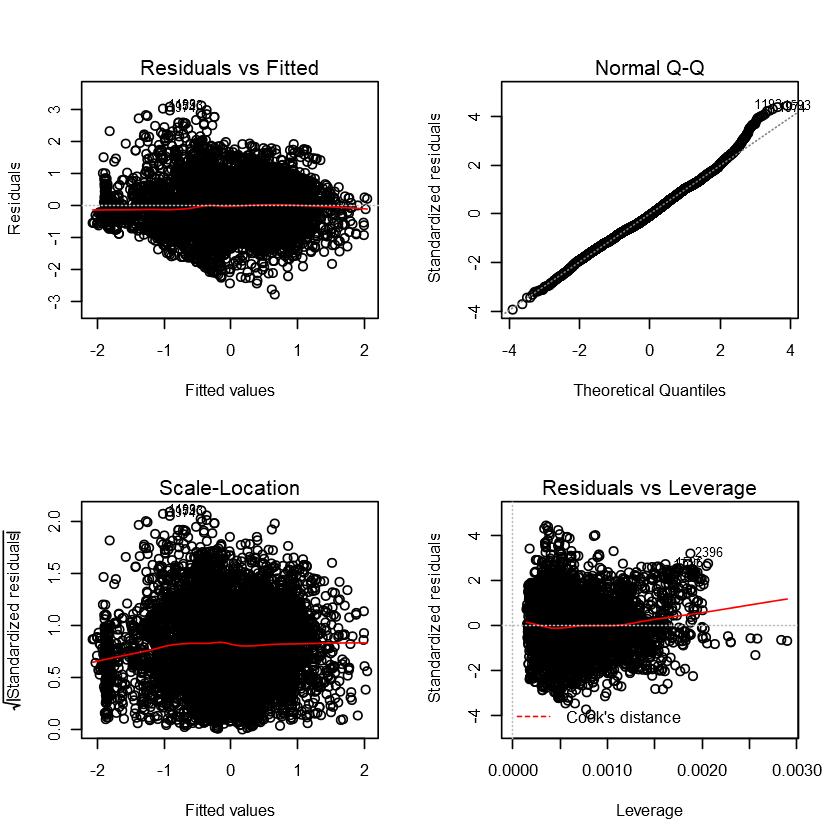

In [33]:
par(mfrow=c(2,2))
plot(model)

1. **Residual vs Fitted**: By looking at this plot we have a good indication that our the predictors have a **<font color="darkred">linear</font>** relationship with `pm`. These because our residuals are linear with respect to 0 as we can observe with the comparison of the red line and the black dashed one around 0. Besides, our residuals are spread equally around the zero without any pattern. 

2. **Normal Q-Q**: By looking at this plot we have a good indication that our the data come from a theoretical **<font color="darkred">normal</font>** distribution as our residuals have a **<font color="darkred">normal</font>** behavior too. We can support this assumption with our residuals following most of the dash black line.

3. **Scale-Location**: By looking at this plot we have a good indication that our data has equal variance. Because even though the red line is not completly horizontal we can see that our residuals are spread equally along the ranges of predictors and seems random. 

* **Residual vs. Leverage**: With this plot we identify that there are not influential data samples in the linear regression analysis, and we do not need to remove any sample from the analysis.


After inspecting the model we proceed to find more predictors in order to improve the performance of the model by increasing Adjusted $R^2$ and F-Statistic. To do that we add some more predictors: Interactions and transformations of all of the attributes selected for the model

### 4.3 Stepwise Selection of Interactions and Transformations<a class="anchor" id="sec_4.3"></a>
After removing the predictor `i_d`, `i_q` and `torque` we proceed to interact all the attributes between them and also squaring all the predictors to understand if there are more relevant predictors for the model.

In [34]:
stepwise_selection1 <- regsubsets(pm ~ . +.:.+I(ambient^2)+I(coolant^2)+I(u_d^2)+I(u_q^2)+I(motor_speed^2), data = subset(train, select=c(-i_d, -i_q, -torque)), nvmax = 30) 
summary1 <- summary(stepwise_selection1)     

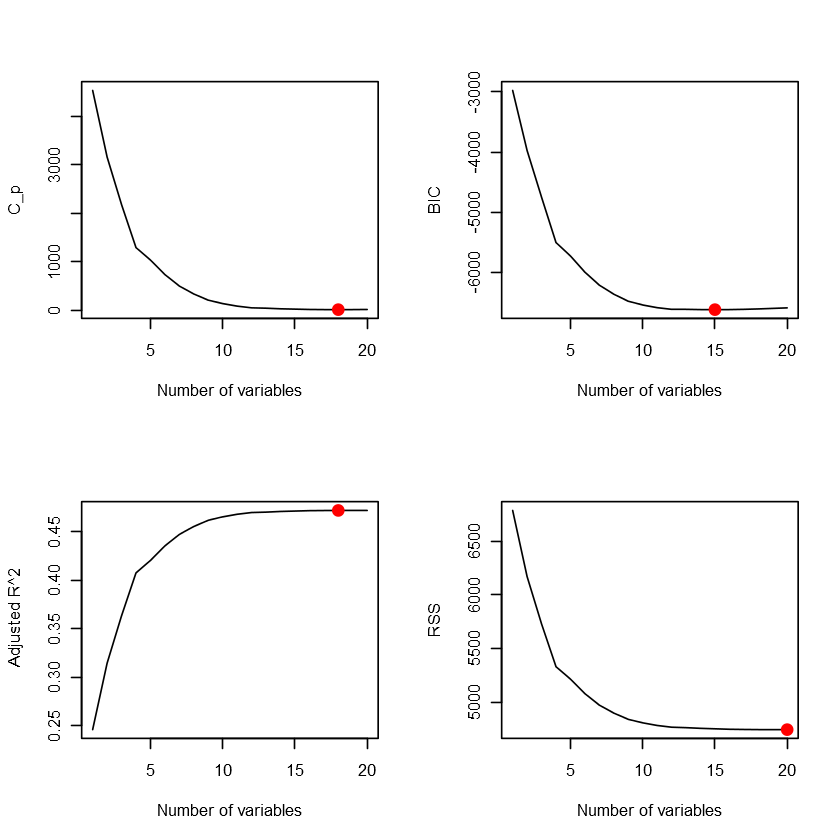

In [35]:
par(mfrow = c(2, 2))
plot(summary1$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(summary1$cp), summary1$cp[which.min(summary1$cp)], col = "red", cex = 2, pch = 20)
plot(summary1$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(summary1$bic), summary1$bic[which.min(summary1$bic)], col = "red", cex = 2, pch = 20)
plot(summary1$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(summary1$adjr2), summary1$adjr2[which.max(summary1$adjr2)], col = "red", cex = 2, pch = 20)
plot(summary1$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
points(which.min(summary1$rss), summary1$rss[which.min(summary1$rss)], col = "red", cex = 2, pch = 20)

By adding the new predictors, we can observe some interesting things:
   - The most optimum model has 18 predictors, having the least `C_p` value, and the highest $R^2$. Making it a little bit complex. 
   - Even though the value of `BIC` and `RSS` are not the minimum, the values of these parameters when the model has 18 parameters is almost the same compared with the optimum value 
   - By comparing the coefficients of each optimum model (model with and without interactions) 
   
   
   model | Min Matthew Cp | Min BIC | Max Adjusted $R^2$ | Min RSS
:-:|:-:|:-:|:-:|:-:|
Without Interactions and Transformations| 7.00 | -8218.78 | 0.421 |7411.03
With Interactions and Transformations| 17.88 | -6622.25 | 0.472 |4743.94

We find out that the model with interactions and transformations have a much better performance in terms of lower RSS, lower BIC and higher $R^2$, even though it is known that it is a more complex model, it could be worth it to try it in terms of performance

Now we will identify the most relevant interactions and predictors of the model as follows

In [36]:
summary1

Subset selection object
Call: regsubsets.formula(pm ~ . + .:. + I(ambient^2) + I(coolant^2) + 
    I(u_d^2) + I(u_q^2) + I(motor_speed^2), data = subset(train, 
    select = c(-i_d, -i_q, -torque)), nvmax = 30)
20 Variables  (and intercept)
                    Forced in Forced out
ambient                 FALSE      FALSE
coolant                 FALSE      FALSE
u_d                     FALSE      FALSE
u_q                     FALSE      FALSE
motor_speed             FALSE      FALSE
I(ambient^2)            FALSE      FALSE
I(coolant^2)            FALSE      FALSE
I(u_d^2)                FALSE      FALSE
I(u_q^2)                FALSE      FALSE
I(motor_speed^2)        FALSE      FALSE
ambient:coolant         FALSE      FALSE
ambient:u_d             FALSE      FALSE
ambient:u_q             FALSE      FALSE
ambient:motor_speed     FALSE      FALSE
coolant:u_d             FALSE      FALSE
coolant:u_q             FALSE      FALSE
coolant:motor_speed     FALSE      FALSE
u_d:u_q              

From the last summary we can identify that the top 3 more relevant predictors are `ambient`, `coolant` and `motor_speed`, the most relevant interaction is `coolant:u_d` being more relevant than `u_d` itself. But at the end we are going to keep all interactions unless `ambient:u_q`, because it causes a worse perfomance to the model. 

Besides, the most relevant transformations are `I(u_q^2)` and `I(motor_speed^2)`. Even though they are the 14 most important predictor, we are going to keep the transformations unless `I(ambient^2)` and `I(u_d^2)` and at the end we get a model with 18 predictors

### 4.4 Model 1.2 -  Linear Model <a class="anchor" id="sec_4.4"></a>
Now that we have our simplest model, we proceed to build a new model with interactions between predictors and transformation of them. With the predictors found in the last stepwise selection

In [47]:
model1.2 <- lm(pm~.+.:.+I(coolant^2)+I(u_q^2)+I(motor_speed^2), 
              data=subset(train, select=c(-i_d, -i_q, -torque)))
summary(model1.2)


Call:
lm(formula = pm ~ . + .:. + I(coolant^2) + I(u_q^2) + I(motor_speed^2), 
    data = subset(train, select = c(-i_d, -i_q, -torque)))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8771 -0.4271 -0.0426  0.4618  3.1773 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -0.120564   0.016596  -7.264 4.01e-13 ***
ambient              0.493124   0.009117  54.089  < 2e-16 ***
coolant              0.271337   0.010245  26.486  < 2e-16 ***
u_d                 -0.054040   0.009773  -5.529 3.29e-08 ***
u_q                 -0.141409   0.017251  -8.197 2.74e-16 ***
motor_speed          0.264425   0.020109  13.149  < 2e-16 ***
I(coolant^2)        -0.023040   0.007953  -2.897 0.003777 ** 
I(u_q^2)             0.054154   0.014129   3.833 0.000127 ***
I(motor_speed^2)     0.116490   0.019345   6.022 1.78e-09 ***
ambient:coolant      0.064545   0.009204   7.013 2.48e-12 ***
ambient:u_d          0.073317   0.009970   7.354 2.06e-13 ***
ambient:

By interacting these predictors and using transformations we found out the the Asjusted R-squared increased from 0.4171 to 0.4719 leading us to think that it is a better model compared to the first one, Even though the F-statistic is closer to 1.
   
Finally, we can see that there are some predictors with a $p-value$ greater than the threshold value $\alpha = 0.05$. `ambient:u_q` and `u_d:u_q`, that is why we are going to remove them.

In [50]:
model1.2 <- lm(formula = pm ~ . + I(coolant^2) + I(u_q^2) + I(motor_speed^2) + ambient:(coolant + u_d + motor_speed) +
            coolant:(u_q + u_d + motor_speed) + motor_speed:(u_d + u_q) ,data = subset(train, select = c(-i_d, -i_q, -torque)))
summary(model1.2)


Call:
lm(formula = pm ~ . + I(coolant^2) + I(u_q^2) + I(motor_speed^2) + 
    ambient:(coolant + u_d + motor_speed) + coolant:(u_q + u_d + 
    motor_speed) + motor_speed:(u_d + u_q), data = subset(train, 
    select = c(-i_d, -i_q, -torque)))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8836 -0.4278 -0.0442  0.4644  3.1838 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -0.122763   0.016579  -7.405 1.42e-13 ***
ambient              0.492011   0.009109  54.013  < 2e-16 ***
coolant              0.272886   0.010214  26.717  < 2e-16 ***
u_d                 -0.054623   0.009767  -5.593 2.29e-08 ***
u_q                 -0.146301   0.017156  -8.528  < 2e-16 ***
motor_speed          0.271159   0.019899  13.627  < 2e-16 ***
I(coolant^2)        -0.023794   0.007944  -2.995  0.00275 ** 
I(u_q^2)             0.060729   0.013593   4.468 7.99e-06 ***
I(motor_speed^2)     0.118505   0.019268   6.150 8.01e-10 ***
ambient:coolant      0.065

Now with the removal of this parameters, we can see that all the predictors have a $p-value$ lower than $\alpha$ and that the Adjusted $R^2$ and F-statistics remain the same.

Finally, we proceed to analize again the residuals of this new model:

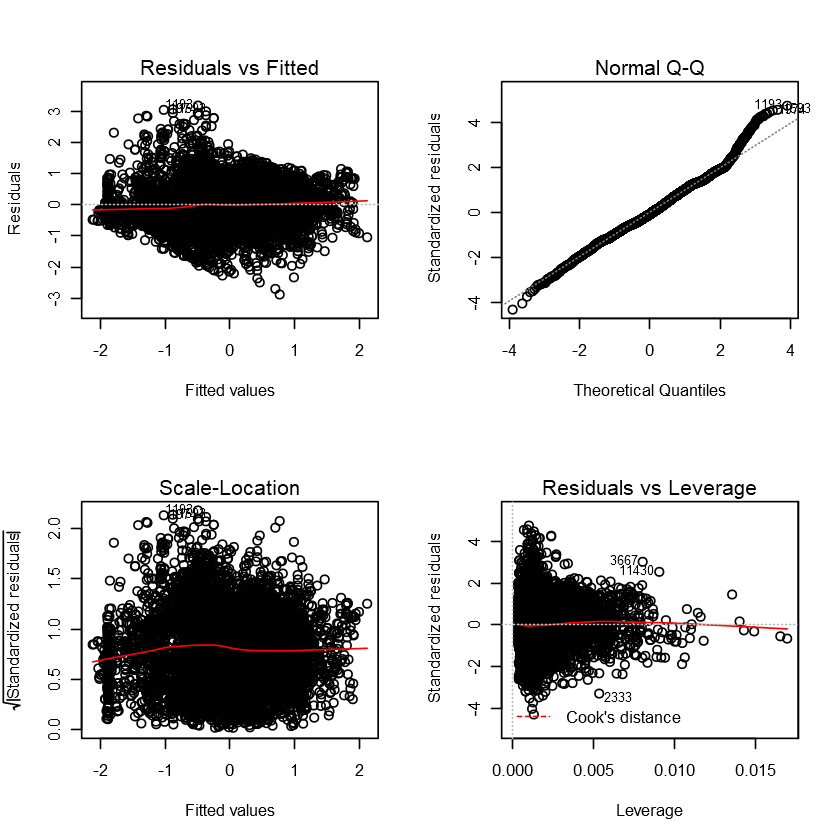

In [51]:
par(mfrow=c(2,2))
plot(model1.2)

And this model is still <font color= "darkred">linear</font>, <font color= "darkred">normal</font>, with <font color= "darkred">constant variance</font>, and without influencial points. As we can see in the plots above.
```



### 4.5 Comparison between Linear Models <a class="anchor" id="sec_4.5"></a>
By using ANOVA test we can verify if the models are different from each other

In [52]:
anova(model1.1, model1.2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
10596,5245.316,NA,NA,NA,NA
10585,4747.514,11,497.8016,100.8993,1.763045e-219


The p-value is almost zero, what can lead us to assume that `model1.1` and `model1.2` are statistically different. It means that these new interactions and transformation did improve the model.

In [85]:
linear.reg <- model1.2 # Select the best model of the comparison
linear.reg


Call:
lm(formula = pm ~ . + I(coolant^2) + I(u_q^2) + I(motor_speed^2) + 
    ambient:(coolant + u_d + motor_speed) + coolant:(u_q + u_d + 
    motor_speed) + motor_speed:(u_d + u_q), data = subset(train, 
    select = c(-i_d, -i_q, -torque)))

Coefficients:
        (Intercept)              ambient              coolant  
           -0.12276              0.49201              0.27289  
                u_d                  u_q          motor_speed  
           -0.05462             -0.14630              0.27116  
       I(coolant^2)             I(u_q^2)     I(motor_speed^2)  
           -0.02379              0.06073              0.11850  
    ambient:coolant          ambient:u_d  ambient:motor_speed  
            0.06531              0.07720             -0.02664  
        coolant:u_q          coolant:u_d  coolant:motor_speed  
            0.15511              0.09715             -0.08801  
    u_d:motor_speed      u_q:motor_speed  
           -0.06994             -0.21474  


### 4.6 Model 2 -  Regularization Regression <a class="anchor" id="sec_4.6"></a>
At this moment we have only done a manually selections of the best predictors for a linear regression model. As there were given 9 diferent predictors that can predict `pm`. There are infinite possibilites of linear models, that is why we have performs all the process showed before.


In order to make the model comparables we create a regularization regression with all the attributes used for the linear model that where pruned by the stepwise selection.

This new regression include all the parameters, the interaction between them and the transformations of them too. And our goal is that with the regularization process, automatically prune all the useless attributes as we did before with stepwise selection

In [123]:
train.mat <- model.matrix(pm ~ ambient + coolant + u_d + u_q + motor_speed + I(ambient^2) + I(coolant^2) + I(u_d^2) + I(u_q^2) + 
                     I(motor_speed^2) + ambient:coolant + ambient:u_d + ambient:u_q + ambient:motor_speed + coolant:u_d +
                     coolant:u_q + coolant:motor_speed + u_d:u_q + u_d:motor_speed + u_q:motor_speed, data = subset(train, select=c(-i_q, -torque)))[,-1]

test.mat <- model.matrix(pm ~ ambient + coolant + u_d + u_q + motor_speed + I(ambient^2) + I(coolant^2) + I(u_d^2) + I(u_q^2) + 
                     I(motor_speed^2) + ambient:coolant + ambient:u_d + ambient:u_q + ambient:motor_speed + coolant:u_d +
                     coolant:u_q + coolant:motor_speed + u_d:u_q + u_d:motor_speed + u_q:motor_speed, data = subset(test, select=c(-i_q, -torque)))[,-1]

#### 4.6.1 Lasso Regularization
As it was said before Lasso Regularization is often used in to select those features automatically, depending on the shrinkage parameter. Therefore it is less time consuming and the processing is quite faster, as it only has one process. This method uses crossvalidation to select the optimal value of $\lambda$ for the loss function.

In [140]:
xmat <- model.matrix(pm~ ambient + coolant + u_d + u_q + motor_speed + I(ambient^2) + I(coolant^2) + I(u_d^2) + I(u_q^2) + 
                     I(motor_speed^2) + ambient:coolant + ambient:u_d + ambient:u_q + ambient:motor_speed + coolant:u_d +
                     coolant:u_q + coolant:motor_speed + u_d:u_q + u_d:motor_speed + u_q:motor_speed,  data=train)
xmat <- xmat[, -1]

Now with the model created we proceed to create a cross-validation with different values of $\lambda$ and see which value of it minimizes the vaue **MSE**

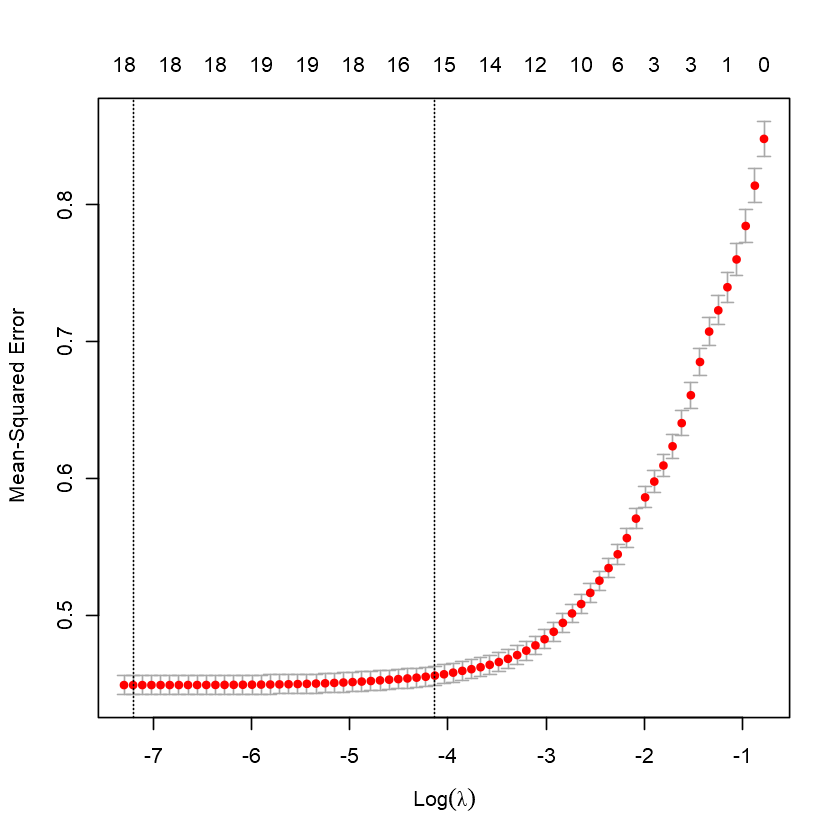

In [141]:
cv.lasso <- cv.glmnet(xmat, train$pm, alpha = 1)
plot(cv.lasso)

In [126]:
best_lambda_lasso <- cv.lasso$lambda.min
best_lambda_lasso

[1] 0.000744793

I can be observe in the plot and with the value of $\lambda$ that the relationship between the shrinkage parameter and the MSE is strongly positive. It means that the smaller the $\lambda$ the smaller the **MSE** too. 

Now with this new value of $\lambda$ chosen with the cross validation we refit our lasso model

In [142]:
fit.lasso <- glmnet(xmat, train$pm, alpha = 1)
lasso.reg <- predict(fit.lasso, s = best_lambda_lasso, newx = test.mat)
lasso.coeff <- predict(fit.lasso, s = best_lambda_lasso, type = "coefficients")[1:7, ]
lasso.coeff

(Intercept)      ambient      coolant          u_d          u_q  motor_speed 
 -0.12069354   0.49300157   0.26778372  -0.05329005  -0.13545152   0.25942751 
I(ambient^2) 
  0.00000000

Now it can be seen that the initial input was 20 different predictors included interactions and transformations. But at the end the algorithm pruned all and found out the the best model uses just 6 different predictors. At the end we are going to see its performance

#### 4.6.2 Ridge Regularization
The last model that we are going to try to fit is the Ridge Regression model, just like Lasso Regularization, this one is used to select those features automatically, depending on the shrinkage parameter.  

In [143]:
grid <- 10^seq(4, -2, length = 100)

And after performing the cross-validation we find out the best $\lambda$ for Ridge Regression

In [144]:
set.seed(1234)# Set seed to get always the same result
fit.ridge <- glmnet(train.mat, train$pm, alpha = 0, lambda = grid, thresh = 1e-12)
cv.ridge <- cv.glmnet(train.mat, train$pm, alpha = 0, lambda = grid, thresh = 1e-12)

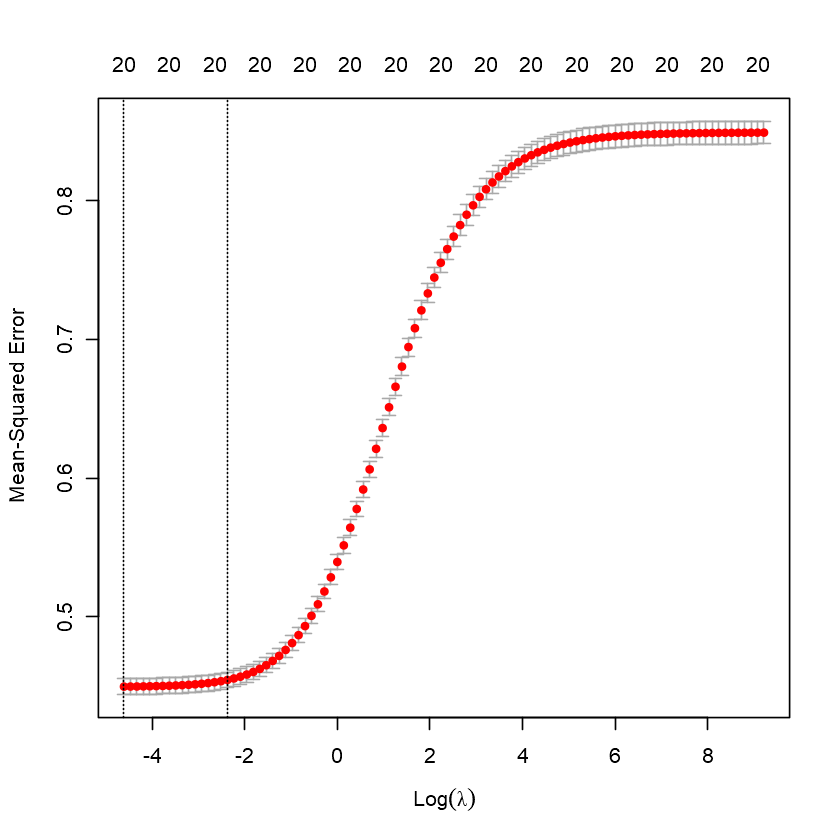

In [145]:
plot(cv.ridge)

In [131]:
best_lambda_ridge <- cv.ridge$lambda.min
best_lambda_ridge

[1] 0.01

And just as Lasso Regression, the relationship between $\lambda$ and **MSE** is strongly positive. The best $\lambda_\text{ridge}$ is 0.01, almost 20 times greater than $\lambda_\text{lasso}$

In [132]:
ridge.reg <- predict(fit.ridge, s = best_lambda_ridge, newx = test.mat)
ridge.coef <- predict(fit.ridge, s = best_lambda_ridge, newx = test.mat, type = "coefficients")[1:7, ]
ridge.coef

(Intercept)      ambient      coolant          u_d          u_q  motor_speed 
-0.163077262  0.488366224  0.265161486 -0.063083779 -0.100704517  0.212615011 
I(ambient^2) 
-0.002173331

The ridge regularization algorithm selected the same predictors chosen by Lasso Regularization. So it took 20 different predictors, pruned most of them and remained with just 6 of them.

## 5. Results and discussion <a class="anchor" id="sec_5"></a>
At the end we have three different models built out from the same parameters to predict the same target value `pm`. And now it is the moment to evaluate the performance of each model using plot methods and **MSE**

### Linear Model vs. True Value
After obtaining the linear model (`linear.reg`) we are going to use it to predict the values of **pm** based on the predictors selected.

In [146]:
prediction <- predict(linear.reg, test)

And with the predicted values we can determine the **MSE** (`Mean Squared Error`) between the prediction and the true value

In [147]:
cat("The MSE between the Linear Model and the True Value of pm is:", mean((prediction - test[,9])^2))

The MSE between the Linear Model and the True Value of pm is: 0.4398689

### Lasso Regression vs. True Value
After obtaining the Lasso Regression (`lasso.reg`) we are going to use it to predict the values of **pm** based on the predictors selected.

In [136]:
cat("The MSE between the Lasso Regularization and the True Value of pm is:", mean((lasso.reg - test$pm)^2))

The MSE between the Lasso Regularization and the True Value of pm is: 0.4398642

### Ridge Regression vs. True Value
After obtaining the Ridge Regression (`ridge.reg`) we are going to use it to predict the values of **pm** based on the predictors selected.

In [138]:
cat("The MSE between the Ridge Regularization and the True Value of pm is:", mean((ridge.reg - test$pm)^2))

The MSE between the Ridge Regularization and the True Value of pm is: 0.4400365

### Visualization of MSE od each model

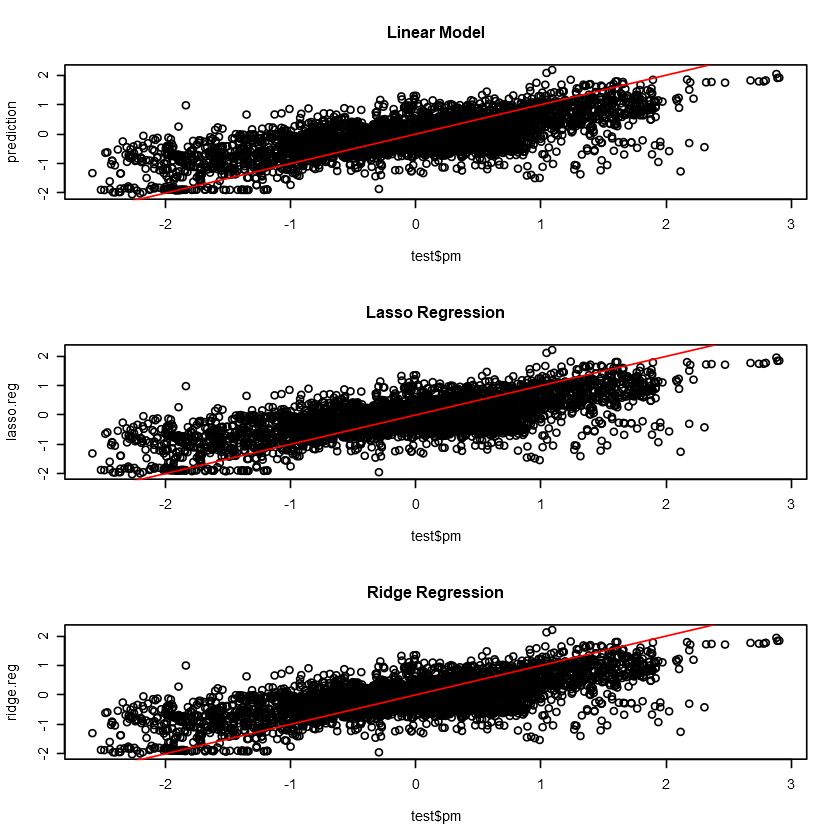

In [155]:
par(mfrow=c(3,1))
plot(test$pm, prediction, main="Linear Model")
lines(test$pm, test$pm, type='l', col="red")
plot(test$pm, lasso.reg, main="Lasso Regression")
lines(test$pm, test$pm, type='l', col="red")
plot(test$pm, ridge.reg, main="Ridge Regression")
lines(test$pm, test$pm, type='l', col="red")

## 6. Conclusion<a class="anchor" id="sec_6"></a>
After developing three different models: `Linear Model`, `Lasso Regression` and `Ridge Regression`, we find out the the models perform pretty similar, based on the value of **MSE** of each model and the plot showing the error around the prediction. 

In the following table it can be seen the comparison between **MSE**:

   Model | MSE
:-:|:-:|
Linear Model| 0.4398689 |
Lasso Regression| 0.4398642 |
Ridge Regression| 0.4400365 |


As it was said before, the performance of each model is quite the same, but we have to consider that one model is pretty complex: `Linear Model`, this one has 18 predictors with many interactions and many transformations between features, was could lead us to think that could be overfitted and it is to complex. That is why we dropped this model.

Now we have two compare between `Ridge` and `Lasso` Regularization, both of them have he same predictors pruned in the same way, and almost the same **MSE**, even though `Lasso Regression` perform a little bit better. Therefore, at the end we chose this one as our model to predict the target value `pm`. But to be honest either of them that we choose between `Lasso` and `Ridge` could be our best model to predict **pm**

## 7. References <a class="anchor" id="sec_7"></a>

[Split dataframes in Train and Test dataframe](https://stackoverflow.com/questions/17200114/how-to-split-data-into-training-testing-sets-using-sample-function)                                            
[Plot lines in a Scatter Plot](http://www.sthda.com/english/wiki/line-plots-r-base-graphs)                    
[Stepwise subset regression](http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/155-best-subsets-regression-essentials-in-r/)                           
[Predict function with stepwise regression](https://github.com/yufree/democode/blob/master/rml/predict.regsubsets.R)